# Comparing Representations

---

__PROBLEM SPACE__

Many choices were made:

- during cleanup (using stop words, lemmatizing, etc.)
- during preprocessing (using a bag-of-upto-trigrams with 2,000 words, performing SVD with 300 components)

Yet, there are still a number of possible stacking of the five main representations (BoT, Tfidf, SVD, new features, spam cosine similarity). The problem space is $2^5 = 32$ stackings out of which only 12 make sense:

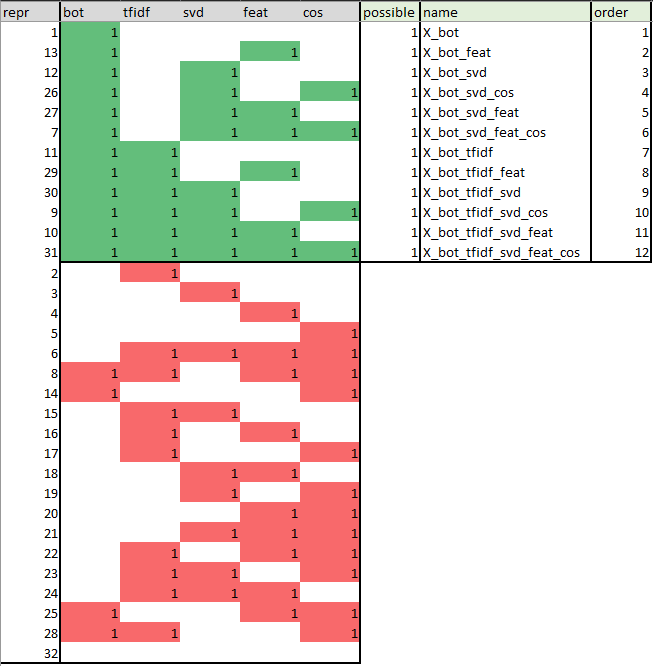

In [1]:
import os
from IPython.display import Image
proc_dir = os.path.join("data","2_processed")
file_path = os.path.join(proc_dir, "possible_representations.PNG")
Image(filename = file_path, width=600)


__RESULTS__

After the preliminary modeling phase with a baseline logistic classifier:

- Overall accuracy and specificity are high enough, sensitivity is the metric that needs improvement
- BoT alone seems to perform quite well, but SVD without Tfidf degrades it
- The more features we add to Tfidf the better it gets, perhaps with the exception of cosine similarities
- Performance with more complex models may vary; further testing is warranted

## Setup

In [2]:
import time

import numpy as np
import pandas as pd

from datetime import datetime

start_time = time.time()
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2020-12-31


## Load Data

In [3]:
import json
import urlextract
from nltk.stem import WordNetLemmatizer

def load_data(data):
    raw_path = os.path.join("data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

# load contractions map for custom cleanup
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

## Feature Engineering

In [4]:
%%capture output

# custom feature engineering module
import custom.feature_engineering as Fe

try:                   
    clean_train_docs, X_feat = Fe.DocumentToFeaturesCounterTransformer().fit_transform(X_train)
except Warning as e:
    pass

# impute with zeros
X_feat[np.isnan(X_feat)] = 0

# create array without RSR
X_feat = np.array(X_feat[:,0:6])

## 12 Representations

### 1. BoT & 7. BoT+Tfidf

In [5]:
import custom.clean_preprocess as cp

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipe = Pipeline([('counter', cp.DocumentToNgramCounterTransformer(n_grams=3)),
                 ('bot', cp.WordCounterToVectorTransformer(vocabulary_size=2000)),
                 ('tfidf', TfidfTransformer(sublinear_tf=True))                  
                ])

X_counter = pipe['counter'].fit_transform(X_train)
X_bot = pipe['bot'].fit_transform(X_counter)
X_bot_tfidf = pipe.fit_transform(X_train)

### 2. BoT+Feat & 8. BoT + Tfidf + Feat

In [6]:
import scipy.sparse as sp

X_bot_feat = sp.hstack((X_bot, X_feat))
X_bot_tfidf_feat = sp.hstack((X_bot_tfidf, X_feat))

### 3. BoT + SVD & 9. BoT + Tfidf + SVD

In [7]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip
from sklearn.preprocessing import MinMaxScaler

def perform_SVD(X, k=300):
    U, Sigma, VT = svds(X.T, # transposed to a term-document matrix
                        k=k) # k = number of components
    # reverse outputs
    Sigma = Sigma[::-1]
    U, VT = svd_flip(U[:, ::-1], VT[::-1])
    
    # return V matrix
    V = VT.T
    
    # scale: this was a mistake, only meant for logistic regression
    # scaling makes random forests extremely slow
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(V)
    
    return X_scaled

X_bot_svd = perform_SVD(X_bot.asfptype())
X_bot_svd = csr_matrix(X_bot_svd)
X_bot_tfidf_svd = perform_SVD(X_bot_tfidf)
X_bot_tfidf_svd = csr_matrix(X_bot_tfidf_svd)

### 4. BoT + SVD + Cos & 10. BoT + Tfidf + SVD + Cos

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

# get all cosine similarities
X_bot_svd_allcos = cosine_similarity(X_bot_svd)
X_bot_tfidf_svd_allcos = cosine_similarity(X_bot_tfidf_svd)

# create dataframe 
data = {'sms':X_train, 'target':y_train}
train_df = pd.DataFrame(data)

# get spam indexes
spam_ix = train_df.loc[train_df['target']=='spam'].index

# calculate average spam similarity on SVDs
mean_spam_sims_bot, mean_spam_sims_tfidf = [], []
for ix in range(X_bot_svd_allcos.shape[0]):
    mean_spam_sims_bot.append(np.mean(X_bot_svd_allcos[ix, spam_ix]))
    mean_spam_sims_tfidf.append(np.mean(X_bot_tfidf_svd_allcos[ix, spam_ix]))

# stack onto previous SVDs
X_bot_svd_cos = sp.hstack((csr_matrix(mean_spam_sims_bot).T, X_bot_svd))
X_bot_tfidf_svd_cos = sp.hstack((csr_matrix(mean_spam_sims_tfidf).T, X_bot_tfidf_svd))

### 5. BoT + SVD + Feat & 11. BoT + Tfidf + SVD + Feat

In [9]:
X_bot_svd_feat = sp.hstack((X_bot_svd, csr_matrix(X_feat)))
X_bot_tfidf_svd_feat = sp.hstack((X_bot_tfidf_svd, csr_matrix(X_feat)))

### 6. BoT + SVD + Feat + Cos & 12. BoT + Tfidf + SVD + Feat + Cos

In [10]:
X_bot_svd_feat_cos = sp.hstack((X_bot_svd, 
                                csr_matrix(X_feat),
                                csr_matrix(mean_spam_sims_bot).T))

X_bot_tfidf_svd_feat_cos = sp.hstack((X_bot_tfidf_svd, 
                                     csr_matrix(X_feat),
                                     csr_matrix(mean_spam_sims_tfidf).T))

## Evaluate Performance on Baseline Logistic Regression

In [11]:
# transform y_array into int type
y_train[y_train=='ham'] = 0
y_train[y_train=='spam'] = 1
y_train = y_train.astype('int')

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, recall_score

log_clf = LogisticRegression(solver="liblinear", random_state=42)

scorer_ = {
    'acc': make_scorer(accuracy_score),
    'tpr': make_scorer(recall_score, pos_label=1),
    'tnr': make_scorer(recall_score, pos_label=0)
}

In [13]:
# list of representations
Xs = [
     X_bot
    ,X_bot_feat
    ,X_bot_svd
    ,X_bot_svd_cos
    ,X_bot_svd_feat
    ,X_bot_svd_feat_cos
    ,X_bot_tfidf
    ,X_bot_tfidf_feat
    ,X_bot_tfidf_svd
    ,X_bot_tfidf_svd_cos
    ,X_bot_tfidf_svd_feat
    ,X_bot_tfidf_svd_feat_cos
]

# list of  names
Xnames = [
     'X_bot'
    ,'X_bot_feat'
    ,'X_bot_svd'
    ,'X_bot_svd_cos'
    ,'X_bot_svd_feat'
    ,'X_bot_svd_feat_cos'
    ,'X_bot_tfidf'
    ,'X_bot_tfidf_feat'
    ,'X_bot_tfidf_svd'
    ,'X_bot_tfidf_svd_cos'
    ,'X_bot_tfidf_svd_feat'
    ,'X_bot_tfidf_svd_feat_cos'
]

In [14]:
accs, tprs, tnrs = [], [], []
for X_ in Xs:
    acc = cross_val_score(log_clf, X_, y_train, cv=10, verbose=0, scoring=scorer_['acc'], n_jobs=-1)
    tpr = cross_val_score(log_clf, X_, y_train, cv=10, verbose=0, scoring=scorer_['tpr'], n_jobs=-1)
    tnr = cross_val_score(log_clf, X_, y_train, cv=10, verbose=0, scoring=scorer_['tnr'], n_jobs=-1)
    accs.append(round(acc.mean(),4))
    tprs.append(round(tpr.mean(),4))
    tnrs.append(round(tnr.mean(),4))

In [15]:
data = {'representation':Xnames,
        'accuracy':accs,
        'sensitivity':tprs,
        'specificity':tnrs}

df = pd.DataFrame(data)
df

,representation,accuracy,sensitivity,specificity
0,X_bot,0.9859,0.9069,0.9979
1,X_bot_feat,0.9849,0.9031,0.9973
2,X_bot_svd,0.9662,0.7602,0.9976
3,X_bot_svd_cos,0.9662,0.7602,0.9976
4,X_bot_svd_feat,0.9646,0.8027,0.9894
5,X_bot_svd_feat_cos,0.9649,0.8046,0.9894
6,X_bot_tfidf,0.9779,0.8450,0.9982
7,X_bot_tfidf_feat,0.9762,0.8604,0.9938
8,X_bot_tfidf_svd,0.9836,0.8857,0.9985
9,X_bot_tfidf_svd_cos,0.9836,0.8857,0.9985


### Visualize

In [16]:
# get vectors for plotting
mean_accs  = [x for x in df.loc[:,"accuracy"]]
mean_sens = [x for x in df.loc[:,"sensitivity"]]
mean_spec  =  [x for x in df.loc[:,"specificity"]]

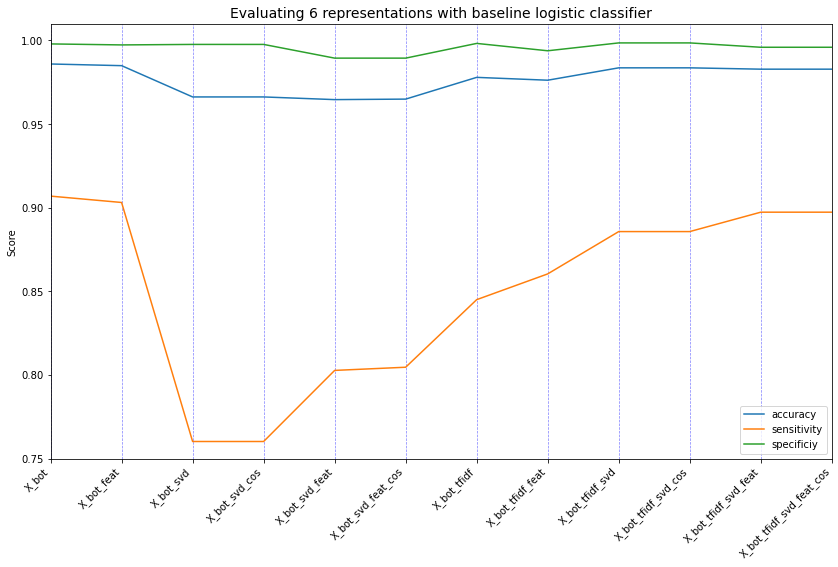

In [17]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(14, 8)) 
plt.plot(mean_accs, label="accuracy")
plt.plot(mean_sens, label="sensitivity")
plt.plot(mean_spec, label="specificiy")
plt.title('Evaluating 6 representations with baseline logistic classifier', fontsize=14)
plt.ylabel('Score')
plt.xticks(np.arange(12), tuple(Xnames))
plt.vlines(np.arange(12), ymin=.75, ymax=1.01, linestyle='dashed', colors='b', alpha=.5, linewidth=.7)
plt.legend(loc="lower right")
plt.axis([0, 11, 0.75, 1.01])
plt.xticks(rotation=45, ha='right')
plt.show()

- Overall accuracy and specificity are high enough, sensitivity is the metric that needs improvement
- BoT alone seems to perform quite well, but SVD without Tfidf degrades it
- The more features we add to Tfidf the better it gets, perhaps with the exception of cosine similarities

## Save 12 representations

In [18]:
for X_, Xname_ in zip(Xs, Xnames):
    filename = ''.join([Xname_, '.npz'])
    file_path = os.path.join(proc_dir, filename)
    sp.save_npz(file_path, X_)    

In [19]:
mins, secs = divmod(time.time() - start_time, 60)
print(f'Time elapsed: {mins:0.0f} m {secs:0.0f} s')

Time elapsed: 1 m 5 s


---